In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import GridSearchCV
import math as ma
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import autograd.numpy as np

# To do elementwise differentiation:
from autograd import elementwise_grad as egrad 
from autograd import grad

In [2]:
class NN:
    
    def __init__(self,
                 X_train,
                 X_test,
                 z_train,
                 z_test,
                 n_hidden_layers,
                 n_hidden_neurons,
                 act_function,
                 n_outputs,
                 innit,
                 classify,
                 out_func):

        self.X_train = X_train
        self.X_test = X_test
        self.z_train = z_train
        self.z_test = z_test
        
        
        if len(self.X_train.shape) > 1:
            self.n_inputs, self.n_features = self.X_train.shape
        elif len(self.X_train.shape) == 1:   
            self.n_inputs = len(self.X_train)
            self.n_features = 1
        
        self.n_outputs = n_outputs  
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_neurons = n_hidden_neurons
        
        
        self.weights = self.weight_create(innit)
        self.biases = self.bias_create()
        self.classify = classify
        
        if classify == 1:
            
            if (out_func == "tanh"):
                self.out_func = self.tanh
                self.check = "tan"
            elif(out_func == "Sigmoid"):
                self.out_func = self.sigmoid
                self.check = "sig"
            else:
                print("Choose tanh or Sigmoid")

        
        if(act_function == "Sigmoid"):
            self.act_function= self.sigmoid
            self.d_act  = self.d_sigmoid
        elif(act_function  == "RELU"):
            self.act_function = self.relu
            self.d_act = self.d_relu
        elif(act_function  == "LRELU"):
            self.act_function= self.lrelu
            self.d_act  = self.d_lrelu
        elif(act_function  == "tanh"):
            self.act_function = self.tanh
            self.d_act  = self.d_tanh
        else:
            print("please choose ,Sigmoid,RELU,LRELU or tanh")
            quit()

    def weight_create(self,innit):  # initilazing weights. all at random between -0.5 and 0.5
        weights = []
      
        if (innit == "Xavier"):
            In_weights = np.random.normal(0, np.sqrt(1.0/self.n_features), (self.n_features, self.n_hidden_neurons))
            weights.append(In_weights)
            for i in range(1, self.n_hidden_layers):
                weights.append(np.random.normal(0, np.sqrt(1.0/self.n_hidden_neurons), (self.n_hidden_neurons, self.n_hidden_neurons)))
            Out_weights = np.random.normal(0, np.sqrt(1.0/self.n_hidden_neurons), (self.n_hidden_neurons, self.n_outputs))
            weights.append(Out_weights)
            return weights
        elif(innit == "He"):
            In_weights = np.random.normal(0, np.sqrt(2.0/self.n_features), (self.n_features, self.n_hidden_neurons))
            weights.append(In_weights) #First weights
            for i in range(1, self.n_hidden_layers):
                weights.append(np.random.normal(0, np.sqrt(2.0/self.n_hidden_neurons), (self.n_hidden_neurons, self.n_hidden_neurons)))
            Out_weights = np.random.normal(0, np.sqrt(1.0/self.n_hidden_neurons), (self.n_hidden_neurons, self.n_outputs))
            weights.append(Out_weights) #last weights
            return weights
        else:
            return print("not a valid weight initilization, Xavier or He")

    def bias_create(self):  # Starting biases all at zero
        biases = []
        #biases for all hidden layers and first hidden layer
        for i in range(0, self.n_hidden_layers):
            biases.append(np.zeros(self.n_hidden_neurons))
        #Biases for output nodes
        O_b = np.zeros(self.n_outputs)
        biases.append(O_b)
        return biases

    def sigmoid(self, x):  # Active function + derivative
        return 1.0/(1.0 + np.exp(-x))
    def d_sigmoid(self,x):
        return self.sigmoid(x)*(1.0-self.sigmoid(x))

    def relu(self, x): # Active function + derivative
        return x * (x > 0)
       
            
          
    def d_relu(self,x):
        return 1.0 * (x > 0)
        
        

    def lrelu(self, x):# Active function + derivative
        alpha = 0.01
        y1 = ((x >= 0) * x)
        y2 = ((x < 0) * x * alpha)
        y = y1 + y2
        return y
    def d_lrelu(self, x):
        alpha = 0.01
        dy1 =((x >= 0) * 1.0)
        dy2 = ((x < 0) * alpha)
        dy = dy1 + dy2
        return dy

    def tanh (self,x): # Active function + derivative
        return np.tanh(x)
    def d_tanh(self,x):
        y = np.tanh(x)
        dy = 1 - y**2
        return dy


    def mini_batch_creator(self,X, y, batch_size):
        mini_batches = [] # empty list for the mini batchess
        if self.n_features == 1:
            data_matrix = np.hstack((X.reshape(-1, 1), y.reshape(-1, 1)))  # Column 0 to n-1 is data, column n is the target data
        elif self.n_features != 1:
            data_matrix = np.hstack((X, y.reshape(-1, 1)))  # Column 0 to n-1 is data, column n is the target data
            
        

        np.random.shuffle(data_matrix) # would not be stochastic if it didnt include random. 

        m = data_matrix.shape[0] // batch_size # number of minibatches number of rows/datapoints divided by selected batchsize
        i=0
        for i in range(m):
            mini_batch = data_matrix[i * batch_size:(i + 1)*batch_size, :]#creating a mini batch
            X_mini = mini_batch[:, :-1] #evry thing except the last column
            Y_mini = mini_batch[:, -1] #exclusively the last column
            mini_batches.append((X_mini, Y_mini)) # has 2 arrays, first array contains the minibatches for x and the second for y
        if data_matrix.shape[0] % batch_size != 0:
            mini_batch = data_matrix[i * batch_size:data_matrix.shape[0]]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1]
            mini_batches.append((X_mini, Y_mini))
        return mini_batches

    def FFD_train(self):
        self.act_list = []
        self.values = []
        z_hidden = np.matmul(self.X_mini_i, self.weights[0]) + self.biases[0]
        self.values.append(z_hidden)
        a_hidden = self.act_function(z_hidden)
        self.act_list.append(a_hidden)
        for layer_i in range(1, self.n_hidden_layers):
            z_hidden = np.matmul(a_hidden, self.weights[layer_i]) + self.biases[layer_i]
            self.values.append(z_hidden)
            a_hidden = self.act_function(z_hidden)
            
            self.act_list.append(a_hidden)
        #Output values
        z_out = np.matmul(a_hidden, self.weights[-1]) + self.biases[-1]
        self.values.append(z_out)
        a_out = z_out
        if self.classify == 1:
            a_out = self.out_func(z_out)
            
        self.act_list.append(a_out)
        return 
    
    def FFD_predict(self, X):  # feed forward pass for test set
        z_hidden = np.matmul(X, self.weights[0]) + self.biases[0]
        a_hidden = self.act_function(z_hidden)
        for layer_i in range(1, self.n_hidden_layers):
            z_hidden = np.matmul(a_hidden, self.weights[layer_i]) + self.biases[layer_i]
            a_hidden = self.act_function(z_hidden)
        z_out = np.matmul(a_hidden, self.weights[-1]) + self.biases[-1]
        if self.classify == 1:
            z_out = self.out_func(z_out)
        nan_check = np.isnan(z_out).any()
        if nan_check == True:
            print("Exploding/vanishing gradient encounterd")
            z_out = np.zeros(z_out.shape)
        return z_out
            
            
        
        
    def back_prop(self):
        #gradient descent solver algorithm 
        def GD_solver(step_size,layer_i):
            if (layer_i == 0):
                gradient_weigths_in = np.matmul(self.X_mini_i.T, step_size)
                gradient_biases_in = np.sum(step_size, axis=0)
                if (self.lmb > 0.0):
                    gradient_weigths_in += self.lmb * self.weights[layer_i]
                #gradient_weigths_in = np.clip(gradient_weigths_in,-100,100) #limiting explosion radius of the gradients
                self.weights[layer_i] = self.weights[layer_i] - self.eta * gradient_weigths_in
                self.biases[layer_i] = self.biases[layer_i] - self.eta * gradient_biases_in
            else:
                gradient_weigths_hidden = np.matmul(self.act_list[layer_i-1].T, step_size)
                #print(gradient_weigths)
                gradient_biases_hidden = np.sum(step_size, axis=0)
                if (self.lmb > 0.0):
                    gradient_weigths_hidden += self.lmb * self.weights[layer_i]
                #gradient_weigths_hidden = np.clip(gradient_weigths_hidden,-100,100) # limiting exploding gradients
                self.weights[layer_i] = self.weights[layer_i] - self.eta * gradient_weigths_hidden
                self.biases[layer_i] = self.biases[layer_i] - self.eta * gradient_biases_hidden
            return
        #Final/ gradient step
        step_size = self.act_list[-1] - self.Y_mini_i #(a^L-t) from my report
        GD_solver(step_size,-1)
        
        
        #start from the last bias and weights toward the input nodes -1 
        for layer_i in range(self.n_hidden_layers-1, 0, -1):
            step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule 
            GD_solver(step_size,layer_i) #  utelizing the GD to solve for optimal
            
        #First gradient step 
        step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule
        GD_solver(step_size_0,0)
        
        return




    def train_nn(self,n_epochs,batch_size,eta = 0.1,lmb = 0):
        self.eta = eta
        self.lmb = lmb
        for epoch in range(n_epochs):
            mini_batches = self.mini_batch_creator(self.X_train,self.z_train,batch_size)
            for batch in mini_batches:
                self.X_mini_i,self.Y_mini_i = batch
                self.Y_mini_i = self.Y_mini_i.reshape(-1,1) # Column vector
                self.FFD_train()
                self.back_prop()
    
    
    def predict (self,X):
        z = self.FFD_predict(X)
        if self.classify == 1:
            if self.check == "sig":
                
                for i in range(len(z)):
                    if z[i] < 0.5:
                        z[i] = int(0)
                    elif z[i] >= 0.5:
                        z[i] = int(1)
                return z.ravel()
            elif self.check == "tan":
                
                for i in range(len(z)):
                    if z[i] < 0.0:
                        z[i] = int(-1)
                    elif z[i] >= 0.0:
                        z[i] = int(1)
                return z.ravel()
                
        else:
            return z







    
    
    
    
    

# Testing simple regression y = x**2 in the report picture, but other variations has een tested to confirm

In [3]:
x = np.linspace(0,1,200)

y  =np.sin(np.pi*x)
n_epochs = 100
batch_size = 10

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state= 11)
print(X_train.shape)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
print(X_test.shape)

(160,)
(40, 1)


In [4]:
own_nn = NN(X_train,X_test,y_train,y_test,1,40,"tanh",1,innit = "He",classify = 0,out_func = "Sigmoid")
own_nn.train_nn(n_epochs,batch_size,eta = 0.01,lmb = 0.01)

y_tilde = own_nn.predict(X_test)


In [5]:
print(y_test)

y_tilde_mean = np.mean(y_tilde,axis = 1)
y_tilde_mean = y_tilde_mean.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print(y_tilde.shape)
print(y_tilde)


X_plot = np.argsort(X_test,axis = 0)
print(X_plot)

[0.38450584 0.49771963 0.39903056 0.20379202 0.3403713  0.74244018
 0.85530974 0.77332333 0.77332333 0.99623282 0.7632183  0.91375937
 0.88630108 0.60300511 0.21922158 0.83852724 0.24991296 0.8117917
 0.98356514 0.         0.03156855 0.66403114 0.9773751  0.98356514
 0.82090888 0.55146151 0.93757514 0.91375937 0.01578624 0.04734299
 0.84702403 0.44199369 0.38450584 0.39903056 0.99473972 0.53822391
 0.96626549 0.68730414 0.8117917  0.94808684]
(40, 1)
[[ 0.45670598]
 [ 0.53584654]
 [ 0.46691407]
 [ 0.33315116]
 [ 0.35895218]
 [ 0.80446044]
 [ 0.82969516]
 [ 0.83643843]
 [ 0.75521014]
 [ 1.01645604]
 [ 0.82605316]
 [ 0.96879259]
 [ 0.86002357]
 [ 0.65359214]
 [ 0.22494793]
 [ 0.90120147]
 [ 0.25858306]
 [ 0.87516983]
 [ 0.97313107]
 [-0.00616467]
 [ 0.02594246]
 [ 0.72065031]
 [ 1.01273761]
 [ 1.01526098]
 [ 0.88413776]
 [ 0.57747551]
 [ 0.98752434]
 [ 0.88835844]
 [ 0.20920053]
 [ 0.0421514 ]
 [ 0.82182572]
 [ 0.47309349]
 [ 0.40841213]
 [ 0.42473475]
 [ 1.01690389]
 [ 0.58134242]
 [ 1.

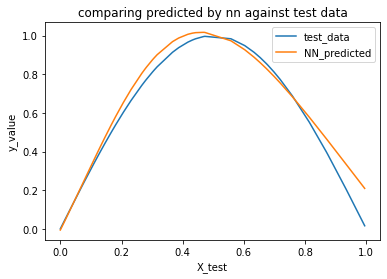

In [6]:
xa = X_test[X_plot].reshape(-1,1)
ya = y_test[X_plot].reshape(-1,1)
y_tildea = y_tilde_mean[X_plot].reshape(-1,1)
plt.plot(xa,ya, label='test_data')
plt.plot(xa,y_tildea, label='NN_predicted')

plt.legend()
plt.xlabel("X_test")
plt.ylabel("y_value")
plt.title("comparing predicted by nn against test data")
plt.show()

In [7]:
mean_squared_error(y_test,y_tilde_mean)

0.002864108360203847

 Seeing from the figure on sine aswell on the untuned network it does manage to find the shape, and is not far off

# Now running some tests on the Franke function

In [8]:
# Franke Function
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [9]:
x = np.linspace(0,1,20)
y = np.linspace(0,1,20)
x_mesh,y_mesh = np.meshgrid(x,y)
print(x_mesh.shape)
x_flat = x_mesh.ravel()
y_flat = y_mesh.ravel()
batch_size = 20

z = FrankeFunction(x_flat,y_flat)

(20, 20)


In [10]:
X = np.hstack((x_flat.reshape(-1,1), y_flat.reshape(-1,1)))
X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
z_test.shape
print(X_test.shape)

(80, 2)


In [23]:
nn_franke = NN(X_train,X_test,z_train,z_test,4,50,"LRELU",1,innit = "He",classify = 0 , out_func = "nje")


In [24]:
nn_franke.train_nn(n_epochs,batch_size,eta = 5.6e-4,lmb = 1e-4)


In [25]:
z_pred = nn_franke.predict(X)

In [26]:
print(z_pred)
print(np.mean(z_pred,axis = 1))


[[0.38895135]
 [0.42365902]
 [0.42519285]
 [0.42573993]
 [0.42559983]
 [0.4243454 ]
 [0.42268494]
 [0.4198969 ]
 [0.41729349]
 [0.41549488]
 [0.41369626]
 [0.41189765]
 [0.41009903]
 [0.40830042]
 [0.40650181]
 [0.40389085]
 [0.40065563]
 [0.39662422]
 [0.39116887]
 [0.38571352]
 [0.3707647 ]
 [0.3900154 ]
 [0.39978633]
 [0.41034636]
 [0.41212018]
 [0.4064025 ]
 [0.40300839]
 [0.39894625]
 [0.39633101]
 [0.39371576]
 [0.39110051]
 [0.38848527]
 [0.38587002]
 [0.38325477]
 [0.38057312]
 [0.37656829]
 [0.37018293]
 [0.36471738]
 [0.3592934 ]
 [0.35386943]
 [0.34755552]
 [0.36541354]
 [0.38499253]
 [0.38634623]
 [0.39021773]
 [0.39729269]
 [0.39483729]
 [0.38986388]
 [0.38354917]
 [0.3778682 ]
 [0.37351806]
 [0.37203977]
 [0.370019  ]
 [0.36731869]
 [0.36251845]
 [0.35627753]
 [0.35003661]
 [0.34379569]
 [0.33755477]
 [0.33131385]
 [0.32771258]
 [0.34175189]
 [0.35731223]
 [0.37892614]
 [0.3780876 ]
 [0.3704469 ]
 [0.37524103]
 [0.37500074]
 [0.37356715]
 [0.36959492]
 [0.36521647]
 [0.36

In [27]:
def plot_z(x,y,z,title):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator, FormatStrFormatter
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title("{}".format(title))
    plt.show()

(20, 20)


C:\Users\Lasse\AppData\Local\Temp/ipykernel_23480/4128832299.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


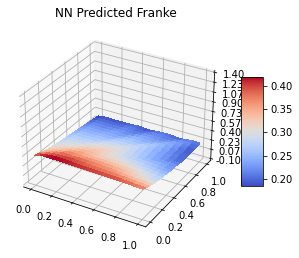

In [28]:
z_mesh = FrankeFunction(x_mesh,y_mesh)
print(z_mesh.shape)


plot_z(x_mesh,y_mesh,z_pred.reshape(z_mesh.shape),"NN Predicted Franke")

Suprised that it does not find the shape of the figure although it does find the corecto colloring

# Testing and verifying the clasification algortihm in the NN also works

In [29]:
from sklearn.datasets import load_breast_cancer

In [30]:
BC = load_breast_cancer()

In [31]:
X = BC.data
z = BC.target
X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)


In [32]:
len(z)
batch_size = 20
n_epochs = 100

In [33]:
from sklearn.metrics import accuracy_score

In [34]:
classy =NN(X_train,X_test,z_train,z_test,2,35,"LRELU",1,innit="Xavier",classify = 1,out_func = "Sigmoid")



In [35]:
classy.train_nn(n_epochs,batch_size,eta = 0.000001,lmb = 0.0001)
z_pred = classy.predict(X_test)
z_tilde = classy.predict(X_train)

In [36]:
z_pred
def accuracy_score_own(test, pred):  # Evaluation method
    return np.sum(test == pred) / len(test)
print(len(z_test))
print(len(z_pred))
print(z_pred)
print(z_test)

114
114
[0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0.]
[0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1
 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1
 1 0 1]


In [37]:
acc = accuracy_score_own(z_test,z_pred)
acc_sickit = accuracy_score(z_test,z_pred)

In [142]:
acc

0.9122807017543859

In [143]:
acc_sickit

0.9122807017543859

# doing a test run for tanh

In [68]:
A = BC.data.copy()
t = BC.target.copy()

t[t==0] = -1

print(t)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1
  1  1  1  1  1 -1 -1  1 -1 -1  1  1  1  1 -1  1 -1 -1  1  1  1  1 -1  1
 -1 -1  1 -1  1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1 -1 -1
  1  1  1 -1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1 -1 -1 -1
  1 -1 -1  1  1  1 -1 -1  1 -1  1 -1 -1  1 -1 -1  1  1 -1  1  1 -1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1 -1  1 -1  1  1 -1
 -1  1  1 -1 -1  1  1  1  1 -1  1  1 -1 -1 -1  1 -1  1 -1  1  1  1 -1  1
  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1
  1  1 -1 -1  1  1  1 -1  1  1  1  1  1 -1 -1  1  1 -1  1  1 -1 -1  1 -1
  1  1  1  1 -1  1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1  1  1  1  1  1 -1  1 -1  1  1 -1  1  1 -1  1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 -1  1  1  1 -1  1 -1  1  1  1  1 -1

In [112]:
A_train, A_test, t_train, t_test = train_test_split(A,t, test_size=0.2)

In [123]:
classy_t =NN(A_train,A_test,t_train,t_test,2,35,"LRELU",1,innit="He",classify = 1,out_func = "tanh")


In [124]:
classy_t.train_nn(n_epochs,batch_size,eta = 0.0000001,lmb = 0.00001)
t_pred = classy_t.predict(A_test)
t_tilde = classy_t.predict(A_train)

In [125]:
accuracy_score(t_test,t_pred)

0.8947368421052632

In [126]:
print(t_test)
print(t_test)

[ 1  1  1 -1  1 -1  1  1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1  1  1 -1  1
  1 -1  1  1  1  1  1  1 -1 -1 -1  1  1 -1 -1  1 -1  1  1 -1 -1  1  1 -1
  1 -1  1  1 -1  1  1  1  1 -1 -1 -1  1 -1  1  1 -1  1 -1 -1  1 -1  1 -1
  1  1 -1 -1  1  1  1  1  1 -1 -1  1  1 -1  1  1  1  1  1 -1 -1  1 -1  1
  1  1 -1  1  1  1  1 -1  1  1 -1 -1 -1 -1 -1  1 -1  1]
[ 1  1  1 -1  1 -1  1  1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1  1  1 -1  1
  1 -1  1  1  1  1  1  1 -1 -1 -1  1  1 -1 -1  1 -1  1  1 -1 -1  1  1 -1
  1 -1  1  1 -1  1  1  1  1 -1 -1 -1  1 -1  1  1 -1  1 -1 -1  1 -1  1 -1
  1  1 -1 -1  1  1  1  1  1 -1 -1  1  1 -1  1  1  1  1  1 -1 -1  1 -1  1
  1  1 -1  1  1  1  1 -1  1  1 -1 -1 -1 -1 -1  1 -1  1]
